In [ ]:
import os

# Define your workspace directory
workspace_dir = '/content/anomaly-detection-in-HEP/code/'

# Create the directory if it doesn't exist
if not os.path.exists(workspace_dir):
    os.makedirs(workspace_dir)

# Change the current working directory to your workspace directory
os.chdir(workspace_dir)

# Verify the current working directory
print('Current working directory:', os.getcwd())


Current working directory: /content/anomaly-detection-in-HEP/code


In [ ]:
from torch.utils.data import DataLoader
from google.cloud import storage
from io import BytesIO
import uproot
from itertools import chain
import numpy as np
import torch
import h5py
from array import array
import os
from models.ode import ode
import torch.optim as optim
from sklearn.metrics import accuracy_score

## Data loading

In [ ]:
def get_data_from_h5(file_dir:str = 'QCD_LLP_samples/preprocessed_data.h5',
                     bucket_name:str = 'cuda-programming-406720'):
  client = storage.Client()
  bucket = client.get_bucket(bucket_name)
  blob = bucket.blob(file_dir)
  file_contents = BytesIO(blob.download_as_string())
  with h5py.File(file_contents, 'r') as f:
    dataset_train = f['train']
    dataset_valid = f['valid']
    dataset_test = f['test']
    d1 = dataset_train[:]
    d2 = dataset_valid[:]
    d3 = dataset_test[:]
  return d1, d2, d3

data_train, data_valid, data_test = get_data_from_h5()

## BDT

In [ ]:
labels_train = data_train[:,-1]
data_train = data_train[:,:5]
labels_test = data_test[:,-1]
data_test = data_test[:,:5]

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# bdt_model = SVC(kernel='rbf')
bdt_model = DecisionTreeClassifier(random_state=40)
bdt_model.fit(data_train, labels_train)

DecisionTreeClassifier(random_state=40)

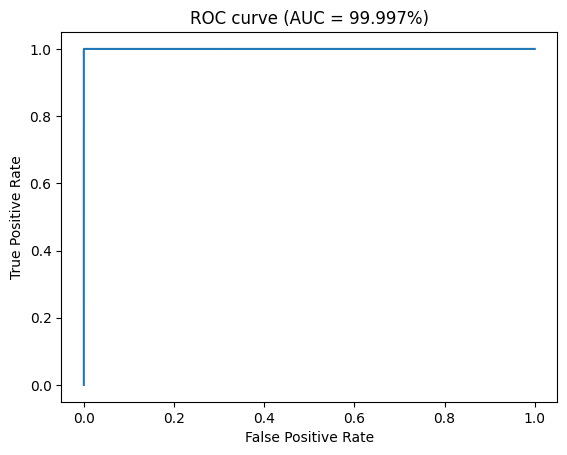

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt

probs = bdt_model.predict_proba(data_test)
fpr, tpr, thresholds = roc_curve(labels_test, probs[:,1])
roc_auc = roc_auc_score(labels_test, probs[:,1])
plt.plot(fpr, tpr)
plt.title('ROC curve (AUC = {:.3f}%)'.format(roc_auc*100))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.savefig(f'docs/roc-curve-{type_model}.pdf', format='pdf')
plt.show()

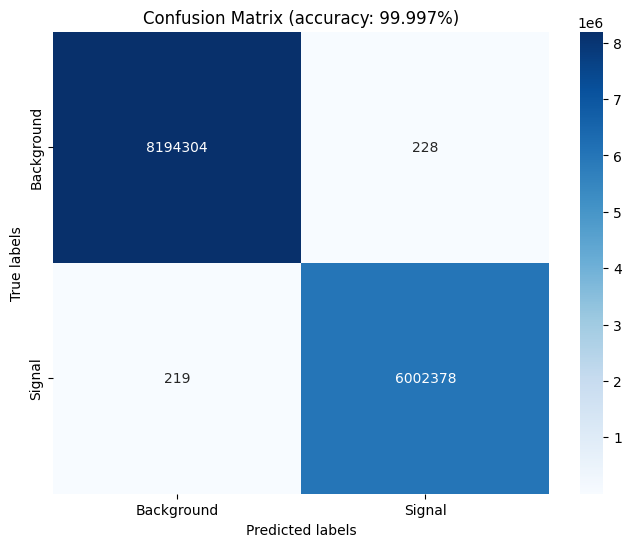

In [ ]:
import seaborn as sns

y_pred = bdt_model.predict(data_test)
cm = confusion_matrix(labels_test, y_pred)
accuracy = accuracy_score(labels_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Background", "Signal"], yticklabels=["Background", "Signal"])
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix (accuracy: {:.3f}%)".format(accuracy*100))
# plt.savefig(f'docs/cm-{type_model}.pdf', format='pdf')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

y_pred = bdt_model.predict(data_test)
report = classification_report(labels_test, y_pred)

with open('bdt-classification_report.txt', 'w') as f:
  f.write(report)

print(report)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00   8194532
         1.0       1.00      1.00      1.00   6002597

    accuracy                           1.00  14197129
   macro avg       1.00      1.00      1.00  14197129
weighted avg       1.00      1.00      1.00  14197129

